# Sales Prediction for Chain of Stores - Capstone
### by Mahendra Shaji Kurian
<img src="./images/Walmart_Logo.png">

## Executive Summary

### Introduction
 
 In Retail Industry and chain of stores one of the biggest issue they face are supply chain management. The component of supply chain management (SCM) involved with determining how best to fulfill the requirements created from the Demand Plan. Its objective is to balance supply and demand in a manner that achieves the financial and service objectives of the enterprise.
  If we look into the case of a retail chain stores one of the basic case is to know the demand of products that are sold in the store. If the decision making authority know whats the demand of each products for a week or month, they would be able to plan the supply chain accordingly. If that is possible this would save a lot of money for them because they don't have to overstock or can plan their Logistics accordingly.
   

### Objective

 To create a model to predict the weekly sales for a chain of stores by analysing the trends of sales over time and the economic features.
 
### Data

 To start this project I am using a dataset from Kaggle. I would be doing my analysis and study on a dataset that gives me the weekly sales data of Walmart.

There are 3 Datasets 
1. Weekly Sales data of 98 departments in 45 stores,
primary key is a combination of (Store,Dept,Date).
2. The Features dataset with economic details like CPI, Unemployment rate, Fuel price etc.. for each week in the region of the Store
primary key here is a combination of (Store,Date)
3. In the third dataset I have area of each store and Type
pirmary key is Store

### Method

 I am breaking this problem into 2 stages
    1. Create a predictive model that predicts the weekly sales of 45 stores (In this stage I am not planning to predict the sales on department Level)
    2. Extend the project to Department Level (Future Work)
    
 I have done basic cleaning of the data I have and did some basic exploratory data analysis. From the insights I have got from the analysis I have further moved to creating models and fine tuning of models. I have used different type of Regression Models and Times Series Analysis to proceed and solve this stage.
 
 **List of Models - **
     1. Lasso Regressor
     2. Random Forest Regressor
     3. Gradient Boosting Regressor
     4. Support Vector Regressor
     5. Time Series Analysis
 
### Conclusion

 I have came up with different models that have helped me to predict the weekly sales of 45 stores with around 94% of accuracy for 3 months(90 Days). Out of the models I ran, I selected the Lasso Regressor as my predictive Model since It gave me the high accuracy of prediction with the lowest residual(error). 
 Even though I have selected one model as of now I am trying to predict sales for 45 stores. I am sure the impact of each feature might be different for different stores because of many reasons and thats why I checked how different is my prediction with each store.

<img src="./images/percentage_prediction_variation.png">

Here the bigger the bubble is the higher the variation in prediction. So we can see that there are 3 stores which have more than 5% variation in prediction. In the future study I can look into these store and try to see what goes wrong and using an ensembling method of getting prediction from different models try to improve the predictions

** From here its a codealong notebook where you can walk through my codes with description**

## Dataset Importing and Querying

I will load all 3 datasets and will merge the datasets into one big dataset that gives whole data. Since I am only predicting Store level sales after the loading I will group by such that I will eliminate Department level data and take the sum of department level sales to give the store level sales.

In [83]:
# Importing all necessary libraries to proceed with this project.

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
# Import timedelta from datetime library
from datetime import timedelta


ss = StandardScaler()
sns.set_style('darkgrid')

In [84]:
sqlite_db = "./datasets/walmart_data.sqlite"
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

### 1. Load Dataset

In [85]:
walmart_path = './datasets/walmart.csv'
walmart = pd.read_csv(walmart_path)

walmart_feature_path = './datasets/walmart_features.csv'
walmart_feature = pd.read_csv(walmart_feature_path)

walmart_store_path = './datasets/walmart_stores.csv'
walmart_store = pd.read_csv(walmart_store_path)

** Group by Store**
Since I am predicting the weekly sales for Store level I am grouping the data in walmart dataset to avoid the department and take the sum of department sales to store level.

In [86]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)


Now I will Merge all the dataset into one place so it will be easier for doing the test and analysis. 

While progressing through this project I was using SQL for writing the data to Local Database and using the join query I have merged data. 

I have changed those to python queries.

In [87]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, walmart_feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)


** The file with 421570 rows has come down to 6435 rows by doing a group by and merge ** 

I will make a SQL DB of this final dataset so that I can use it later without running all this steps or further use in some other area. 


In [88]:
data.to_sql('data',                      # Name of the table
            con=conn,                    # The handle to the file that is setup
            if_exists='replace',         # Overwrite, append, or fail
            index=False) 

### Data Cleaning/Munging
Now I will look through the data and do some basic cleaning and EDA 


In [89]:
print(data.shape)
data.head()

(6435, 15)


,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,1641957.44,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,1611968.17,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,1409727.59,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,1554806.68,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [90]:
# Want to check the date column is in object format or datetime
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

In [91]:
# yes my assumption was correct python have something to do with date format. 
# Now converting "Date" again to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [92]:
# Lets look into the null values
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

** Oh thats huge. More Than 65% of value are missing in MarkDown values**
Let me look through the data describe so that I can impute sum values as of now for the missing 
MarkDown values and will decide later whether to use Markdown for modeling or should take some 
other approach for imputing or whether to discard MarkDowns totally from our case.


In [93]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Size,6435.0,1.302876e+05,63117.022465,34875.000,70713.000,126512.000000,2.023070e+05,2.196220e+05
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
MarkDown1,2280.0,6.855587e+03,8183.310015,0.270,1679.190,4972.590000,8.873583e+03,8.864676e+04
MarkDown2,1637.0,3.218966e+03,9268.082387,-265.760,37.200,187.040000,1.785290e+03,1.045195e+05
MarkDown3,2046.0,1.349853e+03,9287.242800,-29.100,4.700,22.700000,9.998750e+01,1.416306e+05
MarkDown4,1965.0,3.303858e+03,6211.203947,0.220,483.270,1419.420000,3.496080e+03,6.747485e+04
MarkDown5,2295.0,4.435262e+03,5868.933325,135.160,1702.565,3186.520000,5.422080e+03,1.085193e+05


In [94]:
# imputing the values with (-500) since those are missing values and -500 could be a easy way to find the values 
# later and at the same time by putting "NA" the columns types dont have to be changed to Object.
data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

# I am changing this later

In [95]:
# Will convert the bool to 1 and 0 for easier use later.
data.IsHoliday=data.IsHoliday.map(lambda x: 1 if x==True else 0)

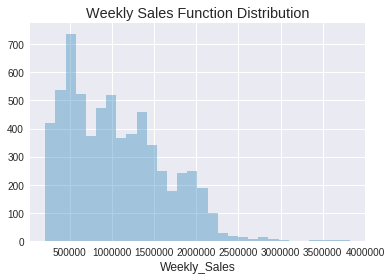

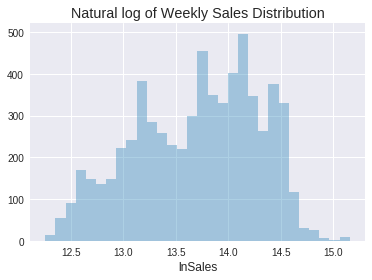

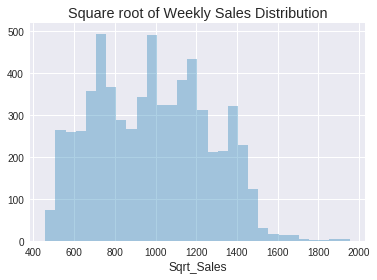

In [96]:
# From the Describe function we see that weekly sales for each store are very high. 
# I will also create Square root function and Natural log of sales because 
# we might be able consider those as our target function

data["Sqrt_Sales"]=np.sqrt(data.Weekly_Sales)
data["lnSales"]=np.log(data.Weekly_Sales+1)


sns.distplot(data.Weekly_Sales, kde=False, bins=30)
plt.title('Weekly Sales Function Distribution')
plt.show()

sns.distplot(data.lnSales, kde=False, bins=30)
plt.title('Natural log of Weekly Sales Distribution')
plt.show()
sns.distplot(data.Sqrt_Sales, kde=False, bins=30)
plt.title('Square root of Weekly Sales Distribution')
plt.show()


In the Distribution Natural Log of Sales and the square root of Sales look better distributed . I might use Natural Log for predictions later


In [97]:
# create dummy variables for 'Type' and keeping all columns to see heatmap then will drop 1 column
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

# Not dropping the orginal Type column now so that I can use the field in some data analysis 

In [98]:
#Create a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map of the 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

## Identify outliers

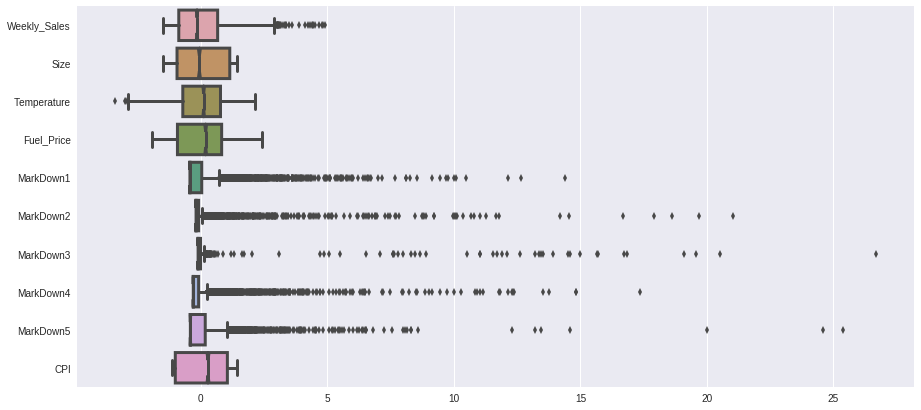

In [99]:
data_box=data_heatmap_df.iloc[:, :10]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

** There are quite a lot of outliers in MarkDown, But Lets first deal the outliers in weekly sales data because we might just drop MarkDowns Later because the percentage of missing values are really high in MarkDowns**

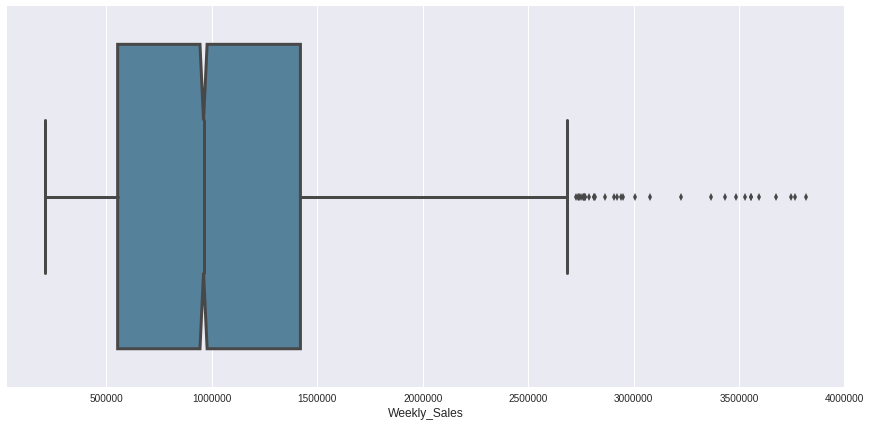

In [100]:
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

ax = sns.boxplot(data.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

In [101]:
# Lets consider 3,000,000 as upper limit 
data[data.Weekly_Sales>3000000].shape

(14, 23)

In [102]:
# there is only 14 outliers. Lets drop it and proceed.
data=data[data.Weekly_Sales<3000000]

## Statistical analysis and correlations

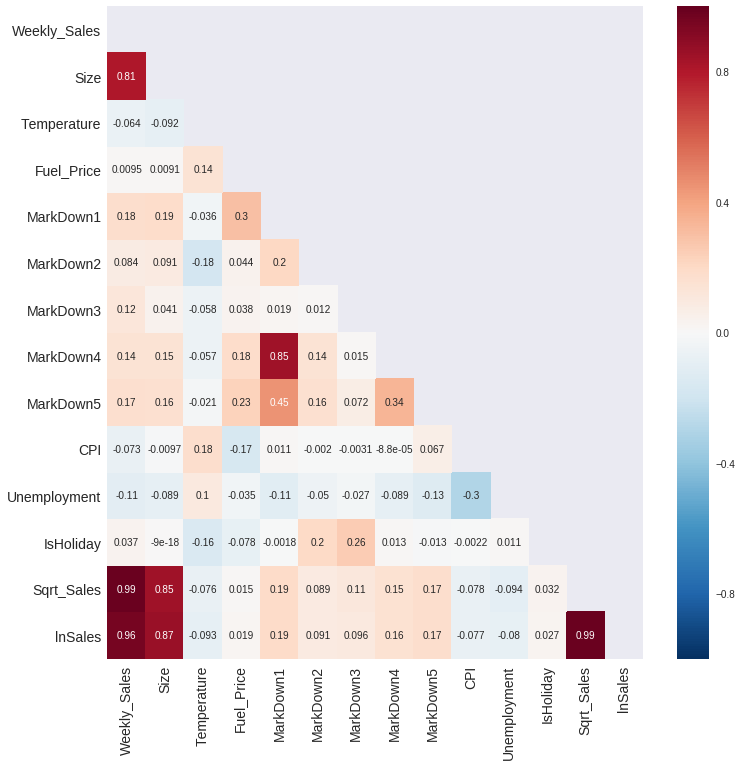

In [103]:
correlation_heat_map(data_heatmap_df)

#inference: By checking the direct correlation of features there is no much promising correlations. 
#           There are no much correlation within the features as well. In a way this is good because 
#           there won't be multicollinearity that we have to take care while running models.


## plotting data

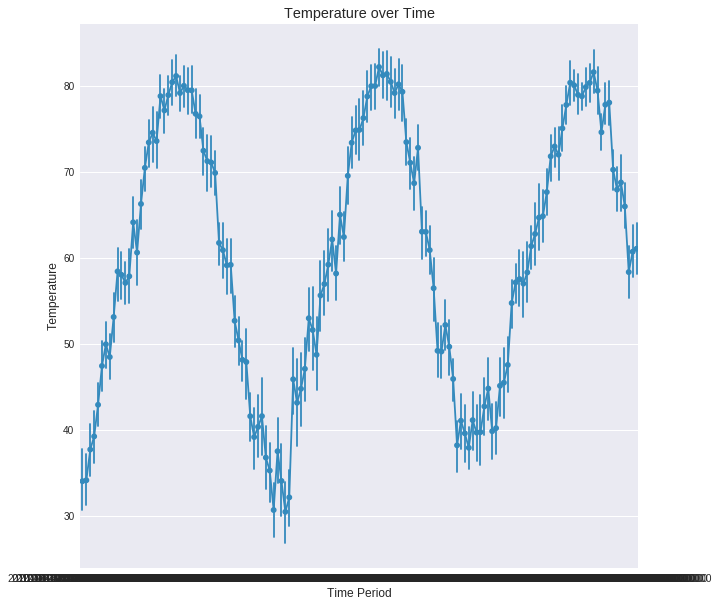

In [104]:
plt.figure(figsize=(10,10))
sns.pointplot(x="Date", y="Temperature", data=data)
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()
# inference: Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would 
# be an interesting data point that we can use for studies further

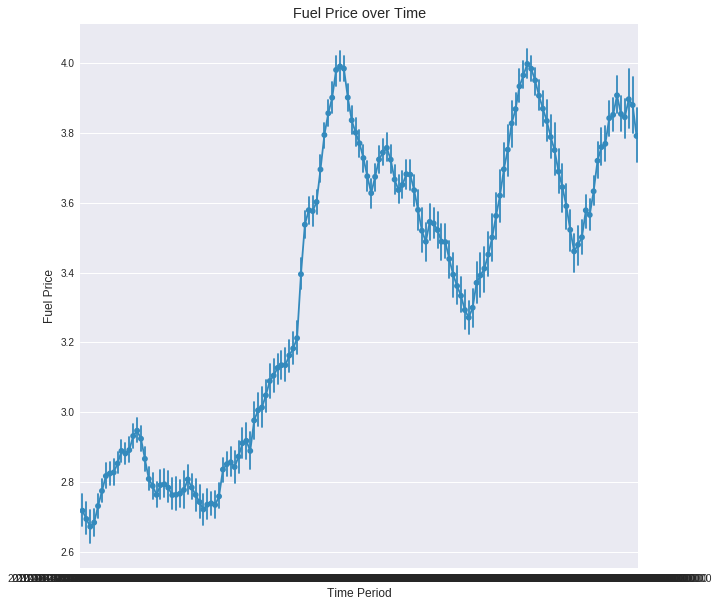

In [105]:
plt.figure(figsize=(10,10))
sns.pointplot(x="Date", y="Fuel_Price", data=data)
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()
# inference: Fuel price varies over time and there are high and lows

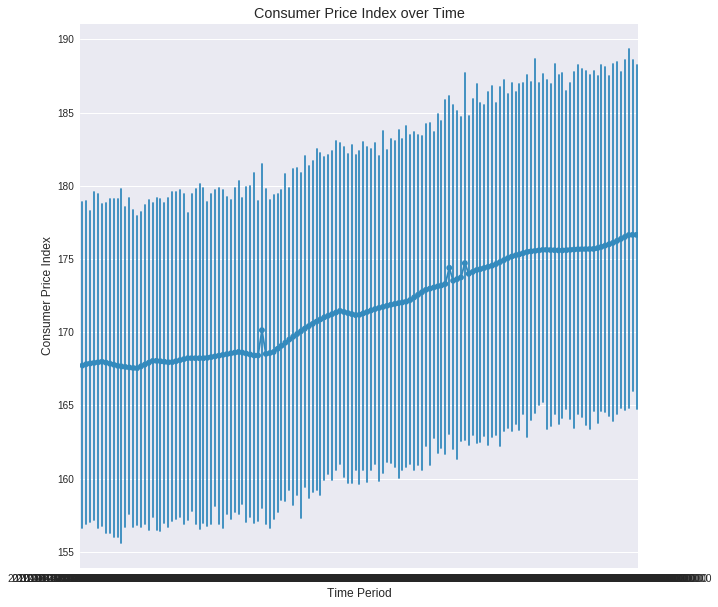

In [106]:
plt.figure(figsize=(10,10))
sns.pointplot(x="Date", y="CPI", data=data)
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()
# inference: over time CPI have increased. but the change is not much

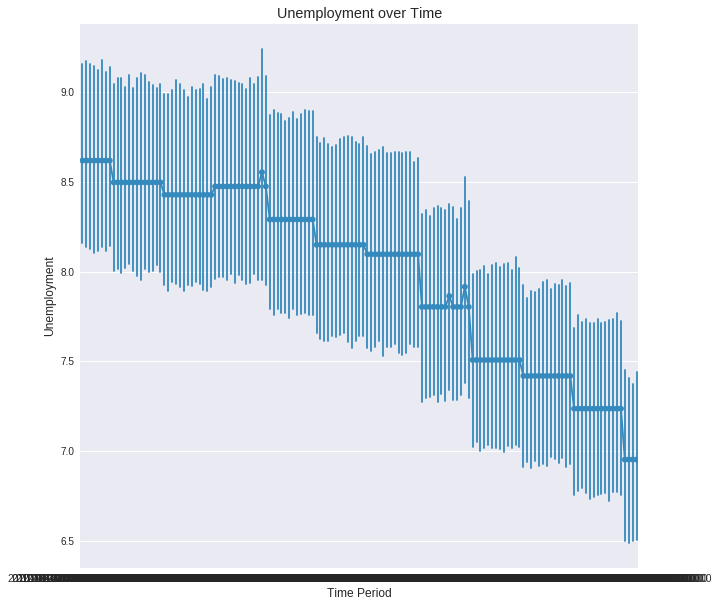

In [107]:
plt.figure(figsize=(10,10))
sns.pointplot(x="Date", y="Unemployment", data=data)
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()
# inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales


** This is interesting. Features over time changes quite a bit. We will see whether these have any effects on Sales while we model **

We know that Markdown columns have quiet few outliers it can be because of our imputation as well. So I will take care of that later and try implement a better way of imputation. Eg: KNN imputation, Random value between min and max imputation..

Weekly Sales also seem to have some Outliers but I am keeping it as of now because in our study outliers can be a good thing to check at.


## Statistical and visual analysis

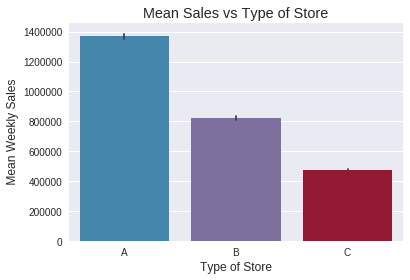

In [108]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Type_vs_Sales.png')
plt.show()

# inference: From the graph its clear that Type A > Type B > Type C in mean weekly sales. 

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


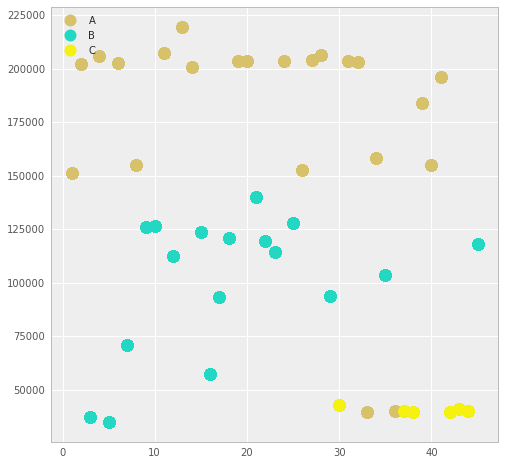

In [109]:
# Lets look through the size of the Store and the the type to see is there any relationship

#credits: Joe Kington Stack overflow
groups = data.groupby('Type')

# Plot
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')

fig, ax = plt.subplots(figsize=(8,8))
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.Store,group.Size, marker='o', linestyle='', ms=12, label=name)
ax.legend(numpoints=1, loc='upper left')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Type_vs_Size.png')
plt.show()

# inference :  From the figure its clear that Type of the Store have a relation ship with the size of the store
#              Type A > Type B > Type C Which is the usual pattern in Size as well as Sales
#              Types might be a classification according to the min sq ft(size) 

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


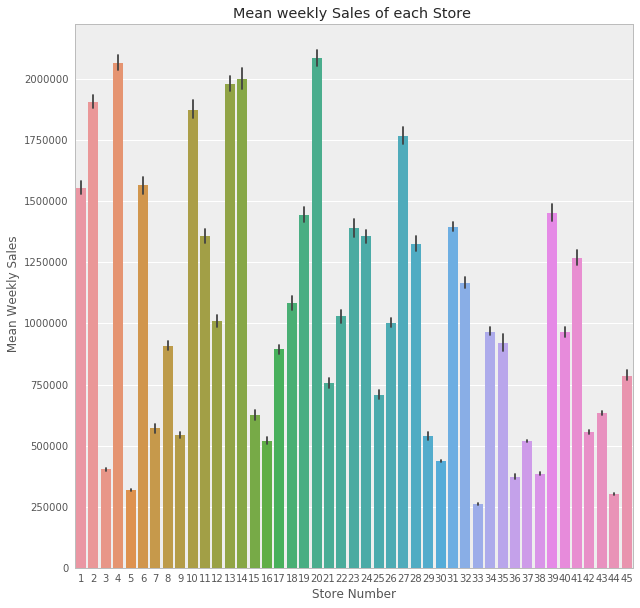

In [110]:
plt.subplots(figsize=(10,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

# inference : From the chart we can see that there are stores that have a weekly sales from $250,000  
#             to $2,200,000

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


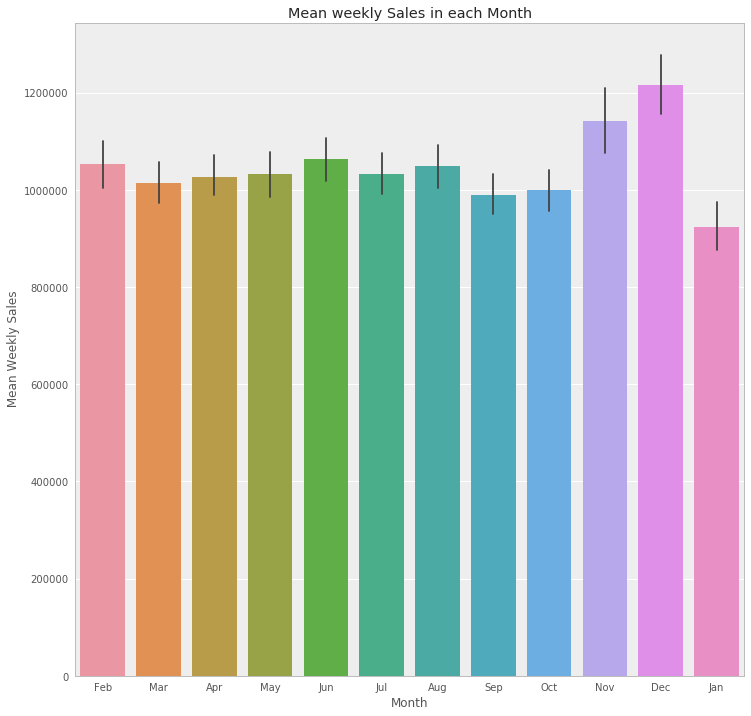

In [111]:
plt.subplots(figsize=(12,12))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Mean_Weekly_Sales_vs_Months.png')
plt.show()
# inference: Graph shows sales in each month and from this we can see December seems to have a very high sales 
#            compared to every other month and January have the least sales. 

#### Summary:
I have done the basic cleaning and EDA.Plots and there inference from it will help me to further go up with modeling and understanding my data. Now I will move on to modeling

### Feature Engineering 
Before creating and running model I will look through the columns and make meaningful columns and create dummies where needed. One another field I have to take care is the Markdown1-5 which have a lot of missing values. 

I will create dummies for **"Store, Month, Year" **

I am planning to change the **DAY** and create dummies out of it. But I guess more than taking the which day it will be better to see **which week of the month** it is, since that can have effect on the sales according to the salary weeks or something else.

**MarkDown1-5** I have to figure out a way to impute and try to use. If I am not able to come up with a good prediction for those I might have to drop some rows


In [112]:
# Create Week column which says which week of the month it is. 
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns that are required for later studies
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [113]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))

In [114]:
# Drop the columns that we have created dummies
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True) 

In [115]:
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 


Now everything else is perfect except **Markdown1-5** columns. I have to deal with those -500 which I have imputed earlier.
** Actually we should just drop those columns since we have around 65% missing value** 

Here in this case I will try **KNN (K Nearest Neighbours) imputation**. This might not be a big success but according to current situation that might be the best way so that I can use those variables for modeling and try how this comes out. Other ways are imputing with 0, median value, random value but those will put same value in all missing data and that can be very miss leading or bad way to do it.
** Lets assume this is a good imputation and see whether there would be any effect in sales according to the MarkDowns**

### KNN model imputation


In [116]:
data.iloc[:,5:10].describe().T

# Inference: more than 50% is missing values with (-500) so imputing with KNN might not be a good idea. 
# But what are the other methods? imputing with random values in the range of that particular columns?
# Lets try that first.


,count,mean,std,min,25%,50%,75%,max
MarkDown1,6421.0,2109.850699,6014.131720,-500.0,-500.0,-500.0,2316.87,88646.76
MarkDown2,6421.0,447.478672,4951.512147,-500.0,-500.0,-500.0,0.03,104519.54
MarkDown3,6421.0,73.717831,5208.957543,-500.0,-500.0,-500.0,3.67,141630.61
MarkDown4,6421.0,663.437052,3857.016987,-500.0,-500.0,-500.0,318.73,67474.85
MarkDown5,6421.0,1257.730712,4229.091574,-500.0,-500.0,-500.0,1966.38,108519.28


In [117]:
data.MarkDown1=data.MarkDown1.map(lambda x: np.nan if x==-500 else x)
data.MarkDown2=data.MarkDown2.map(lambda x: np.nan if x==-500 else x)
data.MarkDown3=data.MarkDown3.map(lambda x: np.nan if x==-500 else x)
data.MarkDown4=data.MarkDown4.map(lambda x: np.nan if x==-500 else x)
data.MarkDown5=data.MarkDown5.map(lambda x: np.nan if x==-500 else x)

In [118]:
missing_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Not including our actual y(Weekly Sales) and Size of store for Markdown since by including weekly sales
# It can be a bad method to use those MarkDown again for predicting weekly sales. 

impute_cols = [c for c in data.columns if not c in ['Weekly_Sales','Date','Sqrt_Sales','lnSales']+missing_cols]

data_imputed=data.copy()


In [119]:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print ("Best R2 value:",np.max(r2s),"\nBest k: ",np.argmax(k_range))
    return np.argmax(k_range)

In [120]:
impute_missing = data.loc[data.MarkDown1.isnull(), :]
impute_valid = data.loc[~data.MarkDown1.isnull(), :]

y = impute_valid.MarkDown1.values
X = impute_valid[impute_cols]

Xs = ss.fit_transform(X)

Best R2 value: 0.133913746037 
Best k:  25


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


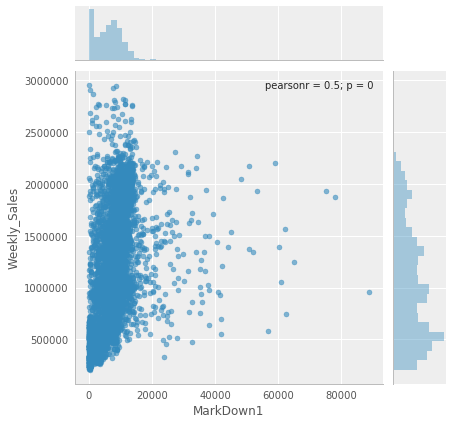

In [121]:
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown1_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown1.isnull(), 'MarkDown1'] = MarkDown1_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown1, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6))
plt.show()

Best R2 value: 0.411133383057 
Best k:  25


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


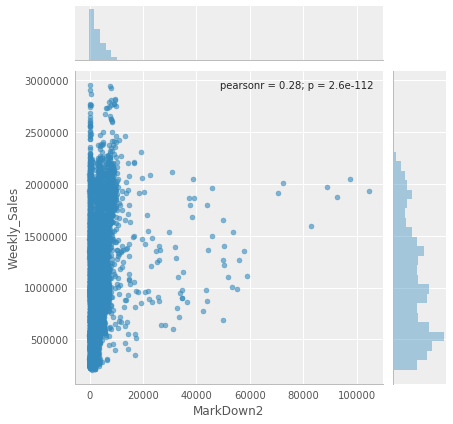

In [122]:
impute_missing = data.loc[data.MarkDown2.isnull(), :]
impute_valid = data.loc[~data.MarkDown2.isnull(), :]

y = impute_valid.MarkDown2.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown2_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown2.isnull(), 'MarkDown2'] = MarkDown2_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown2, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6))
plt.show()

Best R2 value: 0.239816117144 
Best k:  25


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


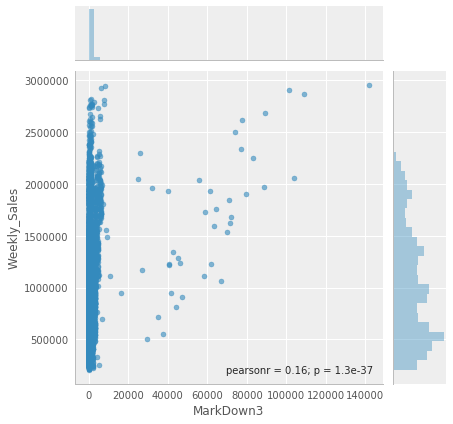

In [123]:
impute_missing = data.loc[data.MarkDown3.isnull(), :]
impute_valid = data.loc[~data.MarkDown3.isnull(), :]

y = impute_valid.MarkDown3.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown3_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown3.isnull(), 'MarkDown3'] = MarkDown3_impute

sns.jointplot(data_imputed.MarkDown3, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6))
plt.show()

Best R2 value: 0.338891159352 
Best k:  25


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


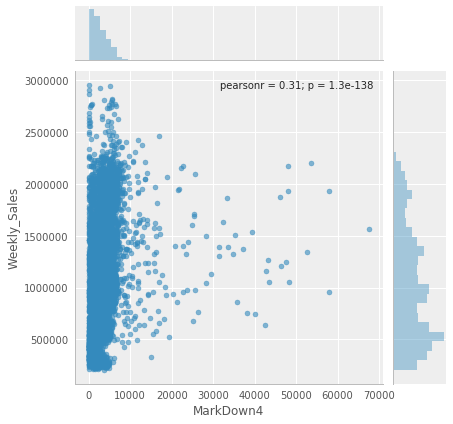

In [124]:
impute_missing = data.loc[data.MarkDown4.isnull(), :]
impute_valid = data.loc[~data.MarkDown4.isnull(), :]

y = impute_valid.MarkDown4.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown4_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown4.isnull(), 'MarkDown4'] = MarkDown4_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6))
plt.show()

Best R2 value: 0.0796712384748 
Best k:  25


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


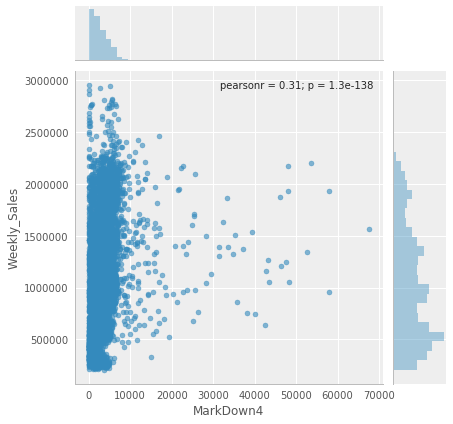

In [125]:
impute_missing = data.loc[data.MarkDown5.isnull(), :]
impute_valid = data.loc[~data.MarkDown5.isnull(), :]

y = impute_valid.MarkDown5.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown5_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown5.isnull(), 'MarkDown5'] = MarkDown5_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6))
plt.show()

In [126]:
walmart_data=data_imputed.copy()

# The accuracy and R2 are very bad. This means that we likely imputing crap with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

So finally we have replaced all missing values in **MarkDown1-5** with **KNN imputation** from the given value range itself. We will see the performance of the model and see through whether we have any better methods. As of now my assumption is KNN imputation values would work because thats the best way we have.

** Lets Try Linear Regression for predicting Weekly_Sales with and without the imputed values and see whether its better to keep the imputed MarkDown Values **


### Modeling


0.948983655434
0.955174119771
Adjusted R^2 0.948388759515
Cross-validated scores: [ 0.96101983  0.96083619  0.95535327  0.94169313  0.96038697  0.95494646
  0.95476855  0.9471128   0.9521823   0.94333534]
Mean Cross validation 0.95316348368


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


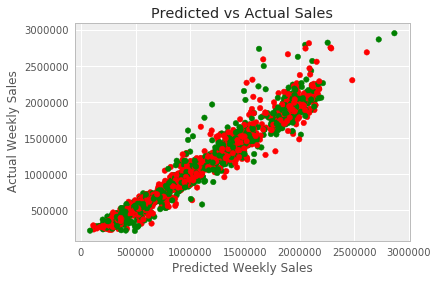

In [129]:
predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales','Sqrt_Sales','lnSales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values 

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
# adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
# print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c=['r','g'], zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

** Now let us look the same model without MarkDowns to check whether data with MarkDown or without MarkDown is good.** 

0.943169989383
0.9509531994
Cross-validated scores: [  7.21481238e-01  -2.94734429e+13  -7.87994595e+13  -2.45528112e+13
  -2.01885973e+13  -8.76265518e+12  -2.63141121e+13  -1.13949255e+11
  -2.15714411e+13  -6.53426662e+10]
Mean Cross validation -2.09841811193e+13


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


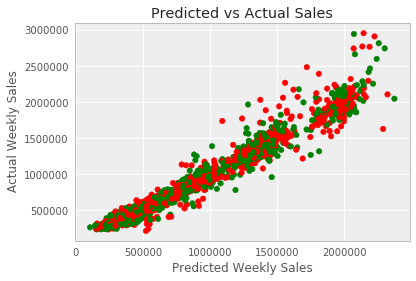

In [46]:
predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales','Sqrt_Sales','lnSales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values 
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c=['r','g'], zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

From the Cross validation its clear that the one with Markdown values are better than they are dropped. So I will keep MarkDowns as of now and **assume** the KNN model have imputed the correct values. 
Now lets move on to real **Modeling** for the prediction of Weekly_sales

We have seen that normal running of Linear regression is a very bad idea. Even though it gives a high R2 value the cross validated score doesn't make any sense. Now its time to go on with **feature selection **


## Tune and evaluate model

### Feature Selection

We have seen the models are giving a terrible crossvalidation score. So lets tune our model. for that first we should figure out what all should we use as our features. For this a feature selection would be the best thing. So lets use Lasso Feature Selection and see how our model works with that.

** Before we start lets shuffle the dataframe a bit because while we use crossvalidation for regressors it won't take a random sample as test and train, instead it takes section by section. Here my Dataframe have data for each store in order. So if we take section by section model might not have enough data to learn about certain stores and which intern will give terrible answers**

In [130]:
data = data_imputed.reindex(np.random.permutation(data_imputed.index))

### Lasso Feature Selection

In [162]:
predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

# I am not using details related to time as my predictors. I will use these in my timeseries model. This is beacuse
# time itself might explain many of the trends and I would like to look more into the effect of other factors.
predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]

X=data[predictors]
X = pd.concat([X,data.ix[:,['Date','Weekly_Sales']] ], axis=1)
y=data.Weekly_Sales.values

#### Test- Train Split such that Test data is last 90 days data (Like a furture 3 months prediction)

In [163]:
# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=X.Date.max()-offset

In [164]:
X_train = X[X.Date < split_date]
y_train = X['Weekly_Sales'][X.Date < split_date]

X_test = X[X.Date > split_date]
y_test = X['Weekly_Sales'][X.Date > split_date]

X_train.reset_index(range(0,len(X_train)),inplace=True)
X_test.reset_index(range(0,len(X_test)),inplace=True)



X.drop(['Date','Weekly_Sales'], axis=1, inplace=True)
X_train.drop(['Date','Weekly_Sales','index'], axis=1, inplace=True)
X_test.drop(['Date','Weekly_Sales','index'], axis=1, inplace=True)

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [165]:
Xs = ss.fit_transform(X)
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)

In [166]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=1000, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=1)

In [167]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
lasso_feat[lasso_feat.coef != 0.]

,abscoef,coef,feature
0,348520.234113,348520.234113,Size
11,171588.899294,171588.899294,Type_A
21,132044.943475,132044.943475,Store_10
19,98333.829130,-98333.829130,Store_8
51,92449.476435,-92449.476435,Store_40
43,89769.949239,-89769.949239,Store_32
44,84766.565637,-84766.565637,Store_33
20,77341.668750,-77341.668750,Store_9
52,77204.254006,-77204.254006,Store_41
45,75185.234177,-75185.234177,Store_34


** The list of features that are seleted and their magnitude of effect on weekly sales can be seen above**

** We will set the predictors that we got from Lasso as our actual predictors and use in further models**

In [168]:
actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values

In [169]:
# Lets see the best alpha score
lasso_cv.alpha_

453.84197291954797

In [170]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=453.84197291954797, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [171]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordin

[ 0.9430689   0.93666334  0.93709546  0.93344028  0.91997249  0.94775818
  0.954022    0.9235665   0.91613768  0.92469518]
0.933641999262


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** Thats great. getting a cross validated score of .933 is good. Now lets use this to predict our last 90 days data which the model don't know about. So if this works well in this test data give a good score and residual is small or comparable to train data we can assume its not overfitting**

In [172]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.960232567142
Adjusted R2:  0.955931345752


In [59]:
train_resids = y_train - best_lasso.predict(X_train_s)
test_resids = y_test - lasso_yhat
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big 
# and in terms of millions

Train Residual 500854703.762
Test Residual 39734329.2102
Residual ratio of Test to Train 0.0793330459149


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size. 


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


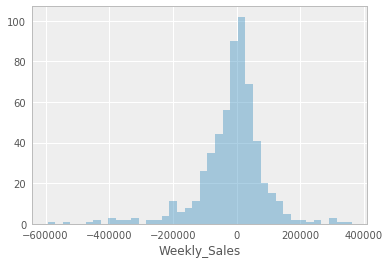

In [60]:
sns.distplot(test_resids, kde=False, bins=40)
plt.show()

# The residuals looks ok and almost like a normal distribution

** Lets see how is the prediction going on with some of the predictors**

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


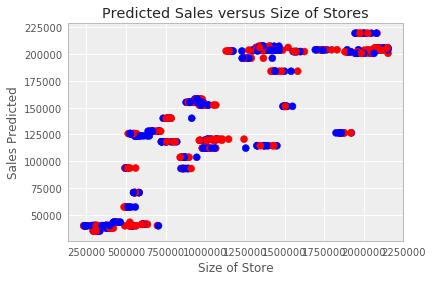

In [61]:
plt.scatter(lasso_yhat,X_test.Size, c=['b','r'])
plt.ylabel('Sales Predicted')
plt.xlabel('Size of Store')
plt.title('Predicted Sales versus Size of Stores')
plt.show()

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


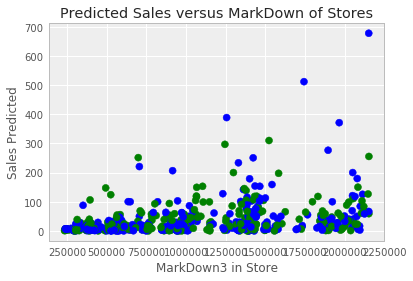

In [62]:
plt.scatter(lasso_yhat,X_test.MarkDown3, c=['b','g'])
plt.ylabel('Sales Predicted')
plt.xlabel('MarkDown3 in Store')
plt.title('Predicted Sales versus MarkDown of Stores')
plt.show()

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


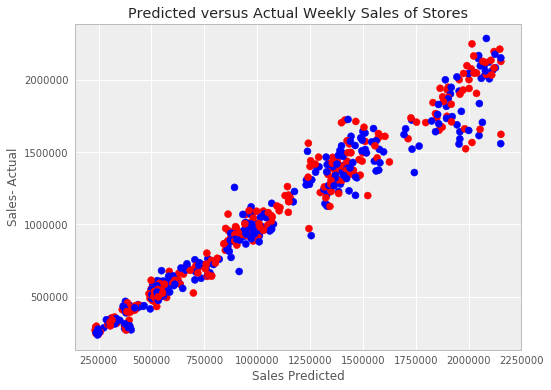

In [63]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test,c=['b','r'])
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Actual_vs_Predicted_Sales.png')
plt.show()

Lasso Model works well giving me a good adjusted R2 and low residual. The residual is also form a normal distribution whcih shows the model is doing not much wierd things. ** The actual vs Predicted Sales looks promising** 

### Setting the predictors from Lasso and Train Test split for further use

I will set my predictors to the ones that are selected from Lasso and will use this predictors and Train Test split for further use in all my models.

In [146]:
predictors=actual_predictors

X=data[predictors]
X = pd.concat([X,data.ix[:,['Date','Weekly_Sales']] ], axis=1)
y=data.Weekly_Sales.values

In [147]:
X_train = X[X.Date < split_date]
y_train = X['Weekly_Sales'][X.Date < split_date]

X_test = X[X.Date > split_date]
y_test = X['Weekly_Sales'][X.Date > split_date].values

X_train.reset_index(range(0,len(X_train)),inplace=True)
X_test.reset_index(range(0,len(X_test)),inplace=True)



X.drop(['Date','Weekly_Sales'], axis=1, inplace=True)
X_train.drop(['Date','Weekly_Sales','index'], axis=1, inplace=True)
X_test.drop(['Date','Weekly_Sales','index'], axis=1, inplace=True)

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Model selection and implementation process

I have already implemented Lasso Regressor and would be looking through and implementing different model of regressors in this part. This is more or a trail and error method with the know models that could do better in Regressions

#### Decision Tree

I have tried a decision tree and it was not working good. The one with max_depth=N gives a good crossvalidation score on train data but when I put that in test data it gives me terrible score. This could be because of over learning or **over fitting**
Now I will go into Random Forest Regressor which is a ensemble method of decision tree and check how it works.

### Random Forest Regressor

In [148]:
rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')

In [149]:
# Fit and crossvalidate on train data
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)

0.94961931368813823

In [150]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.810811527474
Adjusted R2:  0.791928308936


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


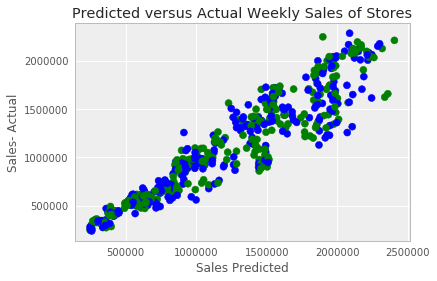

In [69]:
plt.scatter(rfr_yhat, y_test, c=['b','g'])
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()

In [70]:
train_resids = y_train - rfr.predict(X_train_s)
test_resids = y_test - rfr_yhat
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 150910398.424
Test Residual 87195502.2702
Residual ratio of Test to Train 0.57779651489


The cross validated score on train data seems to be very good but test score is not that upto mark which says this might not be the best model. Even when we look into residuals its big compared to the size of train data. So we will move on to another model and see how it would be.

### GradientBoostingRegressor

In [152]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)

In [153]:
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.95012644842337346

In [154]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.77718853664
Adjusted R2:  0.754949351032


In [155]:
train_resids = y_train - gb.predict(X_train_s)
test_resids = y_test - gb_yhat
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 77902937.1821
Test Residual 95307735.476
Residual ratio of Test to Train 1.22341645801


Here we can see the model is learning a lot from train data and gives a cross validated score of .95 where as in the test data the score is .79 which is too low compared to train data. Its not a good sign.
I will check the residuals and here the test residual is higher than train even though the train dataset is much bigger.** This is a clear case of over fitting and we wont use this model further. **

### Support Vector Regression

In [156]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=50000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=500, shrinking=True, tol=0.001, verbose=False)

In [157]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=6)
np.mean(svr_scores)

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMa

0.75002703189581921

In [158]:
svr_yhat=gb.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  0.758951252729
Adjusted R2:  0.734891773246


/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


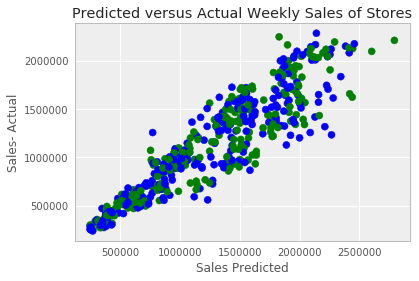

In [78]:
plt.scatter(svr_yhat, y_test, c=['b','g'])
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [159]:
train_resids = y_train - rfr.predict(X_train_s)
test_resids = y_test - svr_yhat
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 150432649.63
Test Residual 95307735.476
Residual ratio of Test to Train 0.633557513683


** This looks good** The cross validation score and score on test data are almost same even though its not a very high percentage. Even the residuals are small. This tells atleast there is no much overfittig.

## TimeSeries Analysis

I have done a timeseries analysis to predict the sales of one store. You will be able to check that in <a href="./capstone_timeseries.ipynb">Capstone Time Series Analysis</a> file. 


<img src="./images/Store1_vs_store2.png">

Above shows the Store1 vs Store2 weekly sales over time. It shows almost the same pattern. Similar spike.

Below we will see how Time Series did the future prediction

<img src="./images/Store1_future_3months.png">

This shows prediction as almost the same as last years. But the error interval is too high which we can see as the shaded area.

** So out of all models the best comes with Lasso regression** I was also looking through one way of taking a mean of the prediction from models thats working quite good but not including that here as I would need to further learn and analyse that more.

In [81]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x  

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [88]:
# Setting the size of bubble according to the percentage change in prediction
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


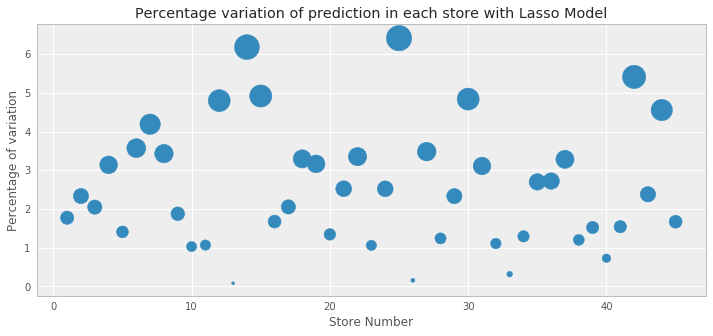

In [92]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s)
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
# plt.savefig('/media/mahendra/GA/capstone_walmart/images/percentage_prediction_variation.png')
plt.show()

This plot shows the variation of prediction or the percentage residual change for each store. Here **the smaller the bubble the better it is** since that shows how predictions are close to actual values. This can be used to futher tune our model because some other model might be doing good with the store which is doing bad in this model.


In [173]:
# Create a dataframe to compare different models
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting','SupportVector')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score,svr_score)
Score["Adj_R2"]=(lasso_adj_r2,rfr_adj_r2,gb_adj_r2,svr_adj_r2)
Score["Test_Residual"]=(lasso_residue,rfr_residue,gb_residue,svr_residue)

## Conclusion
### Interpret findings and relate to goals/criteria

So from the modeling Have found Lasso method works the best by itself with an accuracy of .93. The rain forest regressor and SVR also works good. I have plotted a percentage residual change with bubbles to check how good is the prediction for each store.  This could be a good method to look into each store and see which stores are doing good with this model and which are not. So similarly I could find model that works better for that particular store and make an ensemble model with prediction power for each store assigned to each model.

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


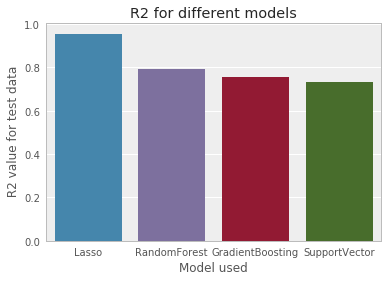

In [174]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Model_Name", y="Adj_R2", data=Score,orient='v')
plt.xlabel('Model used')
plt.ylabel(' R2 value for test data')
plt.title('R2 for different models')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/R2_for_different_models.png')
plt.show()


Here I have found the model that works best for solving my problem statement of predicting the sales of each stores. Lasso Regressor gives the best prediction if we look into the R2 values.

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


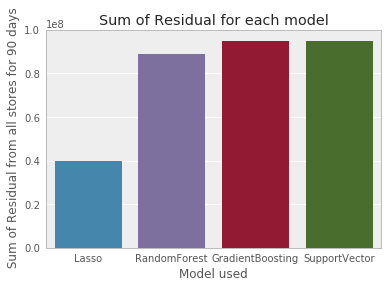

In [101]:
sns.barplot(x="Model_Name", y="Test_Residual", data=Score,orient='v')
plt.xlabel('Model used')
plt.ylabel(' Sum of Residual from all stores for 90 days')
plt.title('Sum of Residual for each model')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Residual_for_different_models.png')
plt.show()

Even The residual for Lasso model is way smaller compared to other models

### Recommendation and Benefits

1. Size of the store is the highest contributing predictor in the model.
2. Store them selves have a prediction power.
3. The Sales are very high in Novermber and December and goes down in january. So its better to employee more staff as casual employee in november and december and encourage permanent staff to take leave on January.
4. The predicted sales data can be used to analyse the sales pattern and adjust the staff in the store. 
5. When I implement the project to department level it helps to plan the inventory and staff from a centralised station to every store, which would help to cost cutting in inventory management, supply chain managemen and human resource.

## Next steps

The Next steps would be 

1. To check into the store that have poor prediction and check deep what makes those bad. 
2. To further improve the predictive model using the ensembling method to combine models and come with better model.
3. Take the data to Department level and to predict the Department level sales which would help to solve the inventory management issues and supply chain management.

### Some Basic Learning

    - From this project I have learned how to collaborate different data and make use of those to solve our problem statements
    - How to use different Regressor Models and the benefits of each Model.
    - When I was doing cross validations first I was getting negative scores at some point. So when I looked more into it I learned crossvalidation for regressors and classifiers works different. This made me learn the flow of my data and how to tackle issue from that side.
    - importance of Timeseries analysis.
    - Lot of Learning on how the projects in retail industry and what kind of projects are there.